In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
data_file = "/Users/liuyuxuan/Downloads/calendar-spread-commodity/DATA.xlsx"

contango_backwardation_sheets = [
    "backwardation_CL", "backwardation_CO", "backwardation_ZNA",
    "contango_HG", "contango_ALE", "contango_GC"
]

seasonal_sheets = ["seasonal_NG", "seasonal_HO", "seasonal_XB"]

all_data = pd.DataFrame()

for sheet in contango_backwardation_sheets:
    prod = sheet.split("_")[-1]
    df = pd.read_excel(data_file, sheet_name=sheet, usecols=[0, 1, 2])
    df.columns = ["Date", f"{prod}_1", f"{prod}_6"]
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna().sort_values("Date")
    df[f"{prod}_Spread"] = df[f"{prod}_1"] - df[f"{prod}_6"]
    all_data = df if all_data.empty else pd.merge(all_data, df, on="Date", how="outer")

for sheet in seasonal_sheets:
    prod = sheet.split("_")[-1]
    df = pd.read_excel(data_file, sheet_name=sheet, usecols=[0, 1, 2])
    df.columns = ["Date", f"{prod}_1", f"{prod}_6"]
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna().sort_values("Date")
    df[f"{prod}_Spread"] = df[f"{prod}_1"] - df[f"{prod}_6"]
    df["Year"] = df["Date"].dt.year
    mean_spread = df.groupby("Year")[f"{prod}_Spread"].mean().reset_index()
    df = pd.merge(df, mean_spread, on="Year", suffixes=("", "_YearMean"))
    all_data = pd.merge(all_data, df[["Date", f"{prod}_1", f"{prod}_6", f"{prod}_Spread"]], on="Date", how="outer")

all_data = all_data.sort_values("Date").set_index("Date")
all_data = all_data.loc[:, ~all_data.columns.str.contains("Spread")]

all_data.tail()


,CL_1,CL_6,CO_1,CO_6,ZNA_1,ZNA_6,HG_1,HG_6,ALE_1,ALE_6,GC_1,GC_6,NG_1,NG_6,HO_1,HO_6,XB_1,XB_6
Date,,,,,,,,,,,,,,,,,,
2024-12-05,68.30,67.22,72.09,71.11,3563.94996,3468.20411,4.1350,4.2870,2614.25,2657.25,2626.6,2728.8,3.079,4.100,2.1557,2.1784,1.9325,1.8585
2024-12-06,67.20,66.52,71.12,70.85,3579.04146,3480.71237,4.1385,4.2870,2549.00,2603.75,2638.6,2740.0,3.076,4.104,2.1326,2.1628,1.9062,1.8411
2024-12-09,68.37,67.52,72.14,70.17,3563.35933,3461.41129,4.2235,4.3640,2524.50,2587.00,2664.9,2768.4,3.182,4.113,2.1835,2.1955,1.9525,1.8707
2024-12-10,68.59,67.66,72.19,71.17,3617.97202,3513.16323,4.2235,4.3580,2518.25,2580.50,2697.6,2801.1,3.163,4.096,2.1861,2.1920,1.9568,1.8627
2024-12-11,69.92,68.59,73.30,71.22,3632.55797,3513.44642,4.2160,4.3425,2535.00,2599.75,2733.8,2831.5,3.376,4.160,2.2162,2.2135,1.9810,1.8761


In [17]:
symbols = {
    'contango': [('HG_1', 'HG_6'), ('ALE_1', 'ALE_6'), ('GC_1', 'GC_6')],
    'backwardation': [('CL_1', 'CL_6'), ('CO_1', 'CO_6'), ('ZNA_1', 'ZNA_6')],
    'seasonal': [('NG_1', 'NG_6'), ('HO_1', 'HO_6'), ('XB_1', 'XB_6')],
}

In [18]:
def strategy_1(front_price, back_price, window=1, type='contango'):
    """
    front_price, back_price: pd.Series with date index and name
    type: 'contango' or 'backwardation'
    Returns:
        weight: DataFrame of strategy weights
        results: DataFrame with absolute PnL and other components
    """
    if type not in ['contango', 'backwardation']:
        print("Seasonal must be converted to contango or backwardated types")
        return

    # Calculate derivatives
    front_deriv = front_price.diff()
    back_deriv = back_price.diff()
    front_deriv = front_deriv.rolling(window).mean()
    back_deriv = back_deriv.rolling(window).mean()

    # Align shapes of the two derivatives
    back_deriv = back_deriv.loc[front_deriv.index]

    # Initialize weight DataFrame
    weight = pd.DataFrame(index=front_deriv.index, columns=[front_price.name, back_price.name])

    # Assign weights based on contango or backwardation
    if type == 'contango':
        weight[front_deriv > back_deriv] = -1
        weight[front_deriv < back_deriv] = 1
        weight[back_price.name] = -weight[front_price.name]
    else:  # type == 'backwardation'
        weight[front_deriv > back_deriv] = 1
        weight[front_deriv < back_deriv] = -1
        weight[back_price.name] = -weight[front_price.name]

    # Shift weight forward by 1 day (to avoid lookahead bias)
    weight = weight.shift(1).fillna(0)

    # Calculate price changes (absolute value changes)
    front_return = front_price.diff().fillna(0)
    back_return = back_price.diff().fillna(0)

    # Calculate absolute PnL based on weight and price changes
    pnl = weight[front_price.name] * front_return - weight[back_price.name] * back_return

    # Combine results into a DataFrame for clarity
    results = pd.DataFrame({
        'Front_Price': front_price,
        'Back_Price': back_price,
        'Weight_Front': weight[front_price.name],
        'Weight_Back': weight[back_price.name],
        'Front_Change': front_return,
        'Back_Change': back_return,
        'PnL': pnl
    })

    return weight, pnl, results


In [19]:
def tune_ticker(ticker_pair, strategy_type, source=None):
    print('Ticker =', ticker_pair)
    front, back = ticker_pair

    # Get the data from all_data directly
    if source == 'seasonal':
        # Only use rows where both seasonal contracts are available
        data_subset = all_data[[front, back]].dropna()
        front_p = data_subset[front]
        back_p = data_subset[back]
    else:
        # Default (contango/backwardation)
        front_p = all_data[front].dropna()
        back_p = all_data[back].dropna()
        data_subset = pd.DataFrame({front: front_p, back: back_p}).dropna()
        front_p = data_subset[front]
        back_p = data_subset[back]

    # Align indexes
    joined = pd.DataFrame({front: front_p, back: back_p}).dropna()
    if source == 'seasonal':
        # Only use rows where both seasonal contracts are available
        data_subset = all_data[[front, back]].dropna()
        front_p = data_subset[front]
        back_p = data_subset[back]
    else:
        # Default (contango/backwardation)
        front_p = all_data[front].dropna()
        back_p = all_data[back].dropna()
        data_subset = pd.DataFrame({front: front_p, back: back_p}).dropna()
        front_p = data_subset[front]
        back_p = data_subset[back]

    best_window, best_return, best_results = None, float('-inf'), None

    for i in range(1, 31):
        weight, pnl, results = strategy_1(front_p, back_p, window=i, type=strategy_type)
        total_return = pnl.sum()

        if total_return > best_return:
            best_window = i
            best_return = total_return
            best_results = results

    print(f"\nBest Window={best_window}, Total Absolute Return={best_return:.4f}")
    print(best_results.head())

    plt.figure(figsize=(12, 6))
    plt.plot(best_results['PnL'].cumsum(), label='Cumulative PnL', linewidth=2)
    plt.title(f"{ticker_pair} | {strategy_type.upper()} | Window={best_window}")
    plt.grid(True)
    plt.legend()
    plt.show()

    return best_window, best_return, best_results




Processing Market Type: CONTANGO

--- Processing Ticker Pair: ('HG_1', 'HG_6') ---
Executing CONTANGO Strategy
Ticker = ('HG_1', 'HG_6')

Best Window=25, Total Absolute Return=8.1725
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       3.3815      3.3485             0            0        0.0000  \
2014-01-03       3.3550      3.3230             0            0       -0.0265   
2014-01-06       3.3595      3.3260             0            0        0.0045   
2014-01-07       3.3595      3.3290             0            0        0.0000   
2014-01-08       3.3425      3.3160             0            0       -0.0170   

            Back_Change  PnL  
Date                          
2014-01-02       0.0000  0.0  
2014-01-03      -0.0255  0.0  
2014-01-06       0.0030  0.0  
2014-01-07       0.0030  0.0  
2014-01-08      -0.0130  0.0  


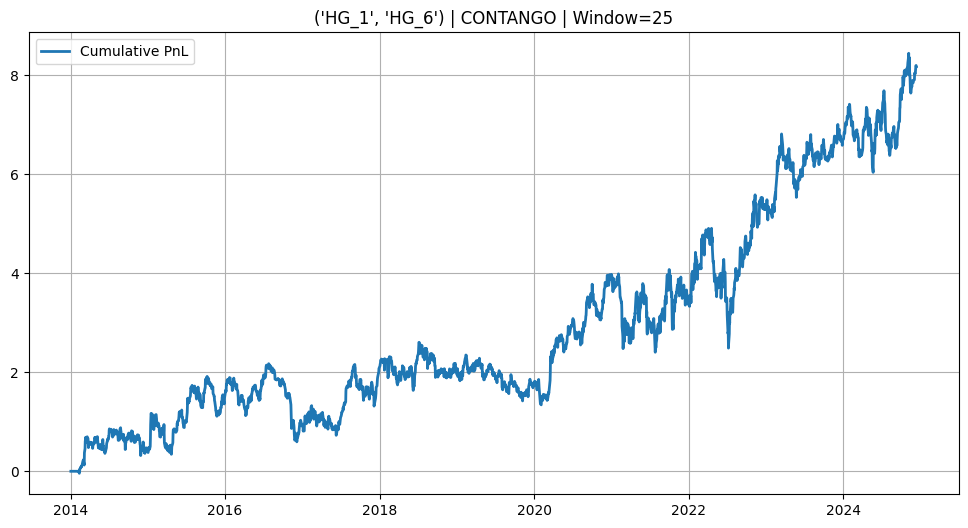


--- Processing Ticker Pair: ('ALE_1', 'ALE_6') ---
Executing CONTANGO Strategy
Ticker = ('ALE_1', 'ALE_6')

Best Window=3, Total Absolute Return=6172.5000
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-05-06      2172.75     2212.75             0            0          0.00  \
2014-05-07      2149.00     2187.00             0            0        -23.75   
2014-05-08      2141.75     2179.75             0            0         -7.25   
2014-05-09      2107.25     2144.50             0            0        -34.50   
2014-05-12      2088.25     2125.50            -1            1        -19.00   

            Back_Change   PnL  
Date                           
2014-05-06         0.00   0.0  
2014-05-07       -25.75   0.0  
2014-05-08        -7.25   0.0  
2014-05-09       -35.25   0.0  
2014-05-12       -19.00  38.0  


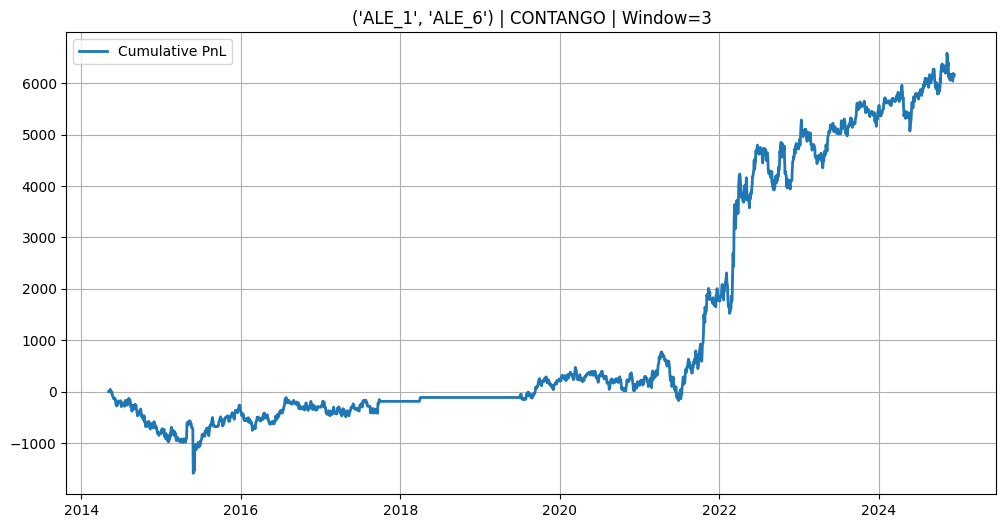


--- Processing Ticker Pair: ('GC_1', 'GC_6') ---
Executing CONTANGO Strategy
Ticker = ('GC_1', 'GC_6')

Best Window=27, Total Absolute Return=897.8000
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       1225.2      1228.6             0            0           0.0  \
2014-01-03       1238.6      1242.2             0            0          13.4   
2014-01-06       1238.0      1241.5             0            0          -0.6   
2014-01-07       1229.6      1233.0             0            0          -8.4   
2014-01-08       1225.5      1228.8             0            0          -4.1   

            Back_Change  PnL  
Date                          
2014-01-02          0.0  0.0  
2014-01-03         13.6  0.0  
2014-01-06         -0.7  0.0  
2014-01-07         -8.5  0.0  
2014-01-08         -4.2  0.0  


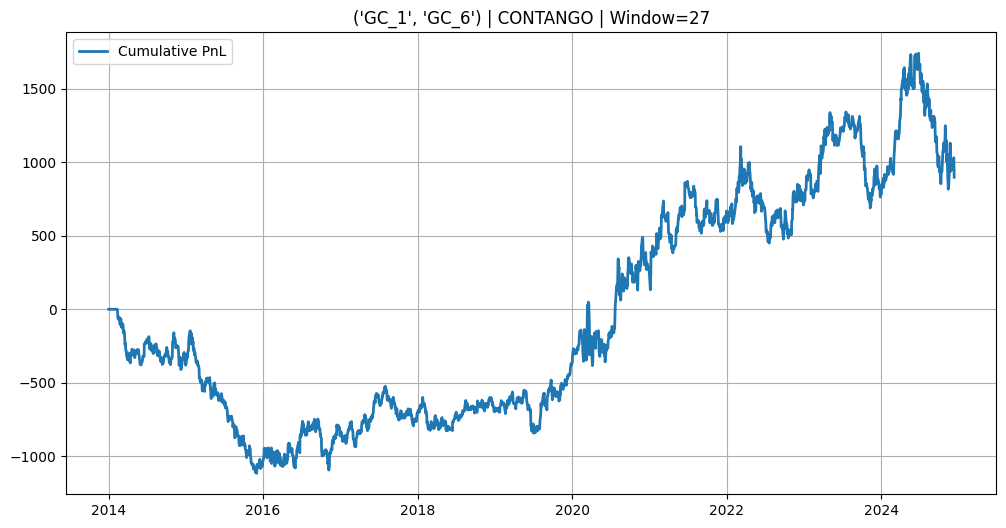


Processing Market Type: BACKWARDATION

--- Processing Ticker Pair: ('CL_1', 'CL_6') ---
Executing BACKWARDATION Strategy
Ticker = ('CL_1', 'CL_6')

Best Window=16, Total Absolute Return=527.8700
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02        95.44       93.95             0            0          0.00  \
2014-01-03        93.96       92.61             0            0         -1.48   
2014-01-06        93.43       92.26             0            0         -0.53   
2014-01-07        93.67       92.16             0            0          0.24   
2014-01-08        92.33       91.07             0            0         -1.34   

            Back_Change  PnL  
Date                          
2014-01-02         0.00  0.0  
2014-01-03        -1.34  0.0  
2014-01-06        -0.35  0.0  
2014-01-07        -0.10  0.0  
2014-01-08        -1.09  0.0  


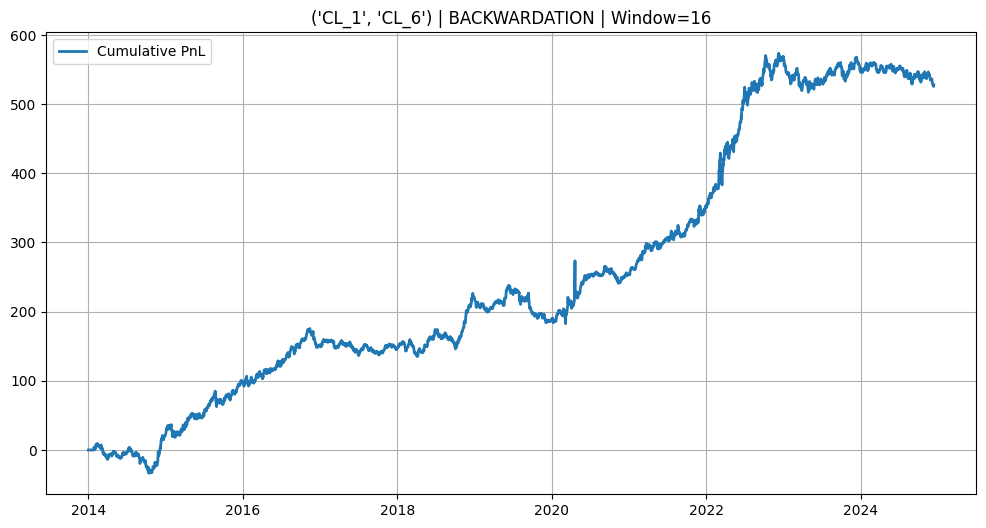


--- Processing Ticker Pair: ('CO_1', 'CO_6') ---
Executing BACKWARDATION Strategy
Ticker = ('CO_1', 'CO_6')

Best Window=2, Total Absolute Return=1625.0600
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       107.78      106.44             0            0          0.00  \
2014-01-03       106.89      105.18             0            0         -0.89   
2014-01-06       106.73      105.32             0            0         -0.16   
2014-01-07       107.35      105.73             1           -1          0.62   
2014-01-08       107.15      105.43            -1            1         -0.20   

            Back_Change   PnL  
Date                           
2014-01-02         0.00  0.00  
2014-01-03        -1.26  0.00  
2014-01-06         0.14 -0.00  
2014-01-07         0.41  1.03  
2014-01-08        -0.30  0.50  


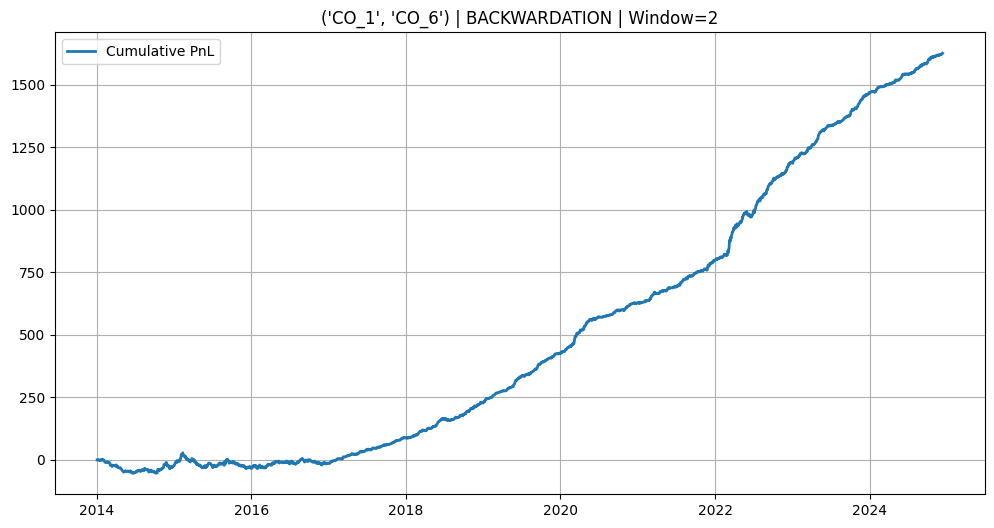


--- Processing Ticker Pair: ('ZNA_1', 'ZNA_6') ---
Executing BACKWARDATION Strategy
Ticker = ('ZNA_1', 'ZNA_6')

Best Window=15, Total Absolute Return=12199.2556
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02   2505.78512  2531.40496             0            0       0.00000  \
2014-01-03   2492.10887  2513.59257             0            0     -13.67625   
2014-01-06   2479.80974  2488.89329             0            0     -12.29913   
2014-01-07   2483.59965  2491.86179             0            0       3.78991   
2014-01-08   2486.11937  2494.38165             0            0       2.51972   

            Back_Change  PnL  
Date                          
2014-01-02      0.00000  0.0  
2014-01-03    -17.81239  0.0  
2014-01-06    -24.69928  0.0  
2014-01-07      2.96850  0.0  
2014-01-08      2.51986  0.0  


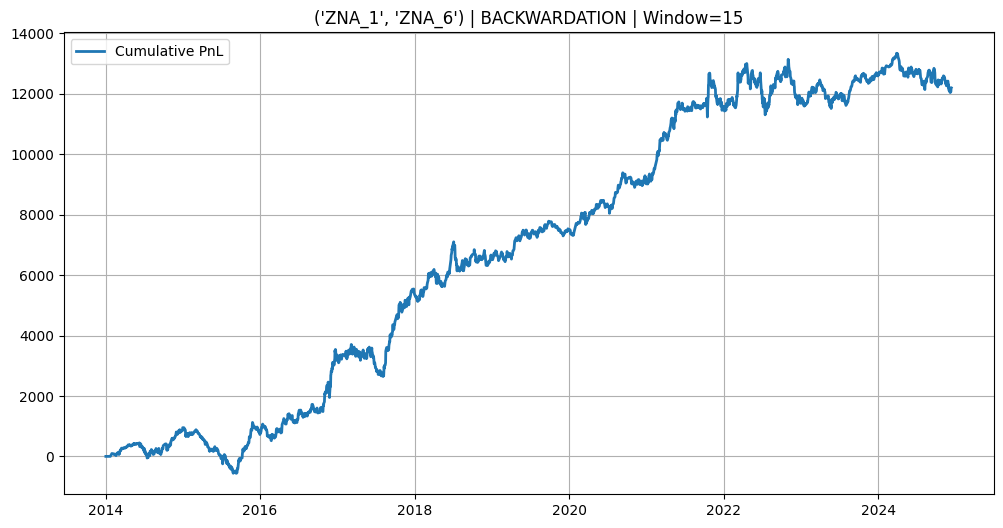


Processing Market Type: SEASONAL

--- Processing Ticker Pair: ('NG_1', 'NG_6') ---
Executing CONTANGO Strategy for Seasonal Data
Ticker = ('NG_1', 'NG_6')

Best Window=1, Total Absolute Return=20.2740
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02        4.321       4.468             0            0         0.000  \
2014-01-03        4.304       4.456             0            0        -0.017   
2014-01-06        4.306       4.470             1           -1         0.002   
2014-01-07        4.299       4.434             1           -1        -0.007   
2014-01-08        4.216       4.345            -1            1        -0.083   

            Back_Change    PnL  
Date                            
2014-01-02        0.000  0.000  
2014-01-03       -0.012  0.000  
2014-01-06        0.014  0.016  
2014-01-07       -0.036 -0.043  
2014-01-08       -0.089  0.172  


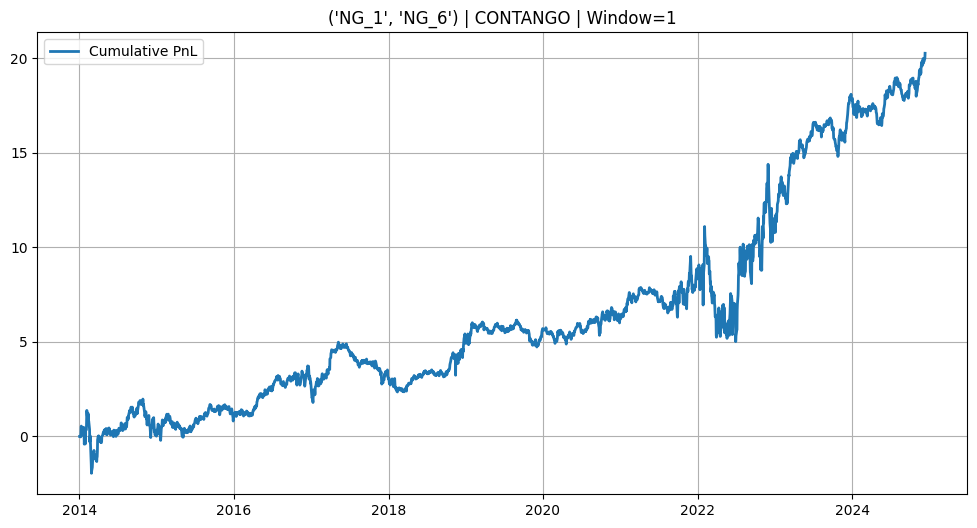

Executing BACKWARDATION Strategy for Seasonal Data
Ticker = ('NG_1', 'NG_6')

Best Window=17, Total Absolute Return=29.3150
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02        4.321       4.468             0            0         0.000  \
2014-01-03        4.304       4.456             0            0        -0.017   
2014-01-06        4.306       4.470             0            0         0.002   
2014-01-07        4.299       4.434             0            0        -0.007   
2014-01-08        4.216       4.345             0            0        -0.083   

            Back_Change  PnL  
Date                          
2014-01-02        0.000  0.0  
2014-01-03       -0.012  0.0  
2014-01-06        0.014  0.0  
2014-01-07       -0.036  0.0  
2014-01-08       -0.089  0.0  


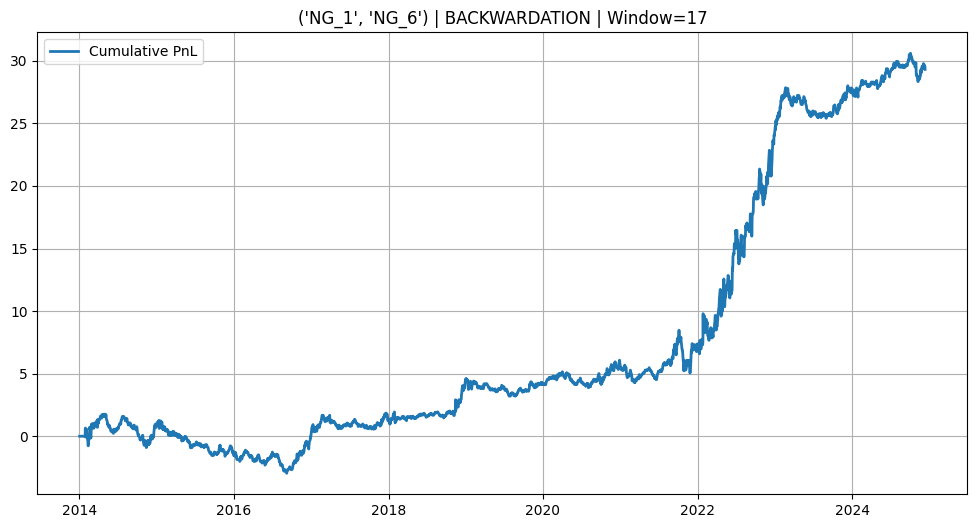


--- Processing Ticker Pair: ('HO_1', 'HO_6') ---
Executing CONTANGO Strategy for Seasonal Data
Ticker = ('HO_1', 'HO_6')

Best Window=11, Total Absolute Return=-0.9022
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       2.9867      2.9044             0            0        0.0000  \
2014-01-03       2.9394      2.8673             0            0       -0.0473   
2014-01-06       2.9388      2.8749             0            0       -0.0006   
2014-01-07       2.9593      2.8755             0            0        0.0205   
2014-01-08       2.9494      2.8722             0            0       -0.0099   

            Back_Change  PnL  
Date                          
2014-01-02       0.0000  0.0  
2014-01-03      -0.0371  0.0  
2014-01-06       0.0076 -0.0  
2014-01-07       0.0006  0.0  
2014-01-08      -0.0033  0.0  


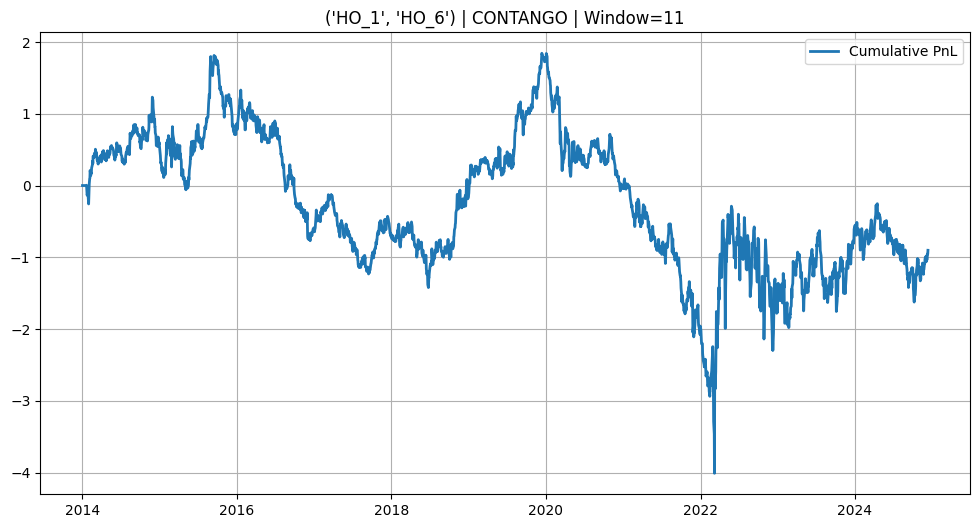

Executing BACKWARDATION Strategy for Seasonal Data
Ticker = ('HO_1', 'HO_6')

Best Window=5, Total Absolute Return=8.5819
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       2.9867      2.9044             0            0        0.0000  \
2014-01-03       2.9394      2.8673             0            0       -0.0473   
2014-01-06       2.9388      2.8749             0            0       -0.0006   
2014-01-07       2.9593      2.8755             0            0        0.0205   
2014-01-08       2.9494      2.8722             0            0       -0.0099   

            Back_Change  PnL  
Date                          
2014-01-02       0.0000  0.0  
2014-01-03      -0.0371  0.0  
2014-01-06       0.0076 -0.0  
2014-01-07       0.0006  0.0  
2014-01-08      -0.0033  0.0  


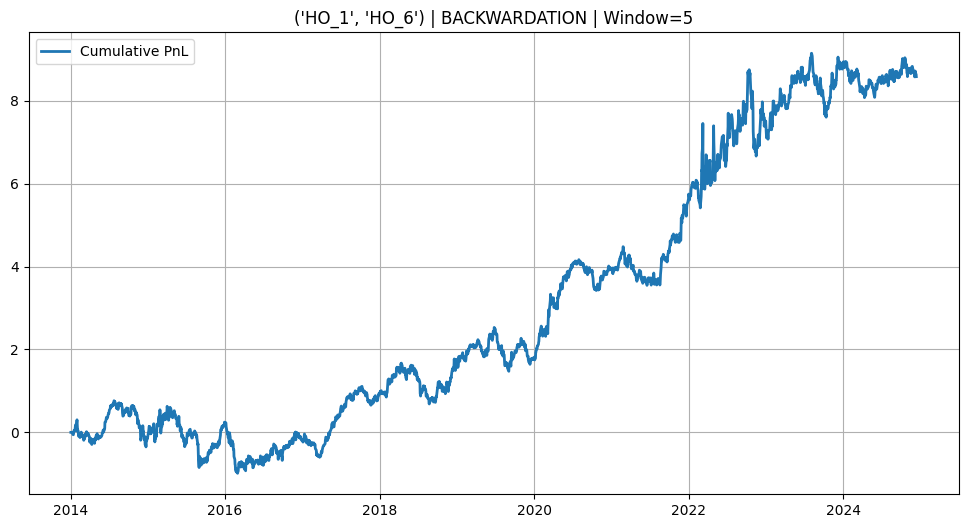


--- Processing Ticker Pair: ('XB_1', 'XB_6') ---
Executing CONTANGO Strategy for Seasonal Data
Ticker = ('XB_1', 'XB_6')

Best Window=8, Total Absolute Return=6.0109
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       2.6950      2.5264             0            0        0.0000  \
2014-01-03       2.6488      2.4956             0            0       -0.0462   
2014-01-06       2.6460      2.5018             0            0       -0.0028   
2014-01-07       2.6786      2.5143             0            0        0.0326   
2014-01-08       2.6563      2.5009             0            0       -0.0223   

            Back_Change  PnL  
Date                          
2014-01-02       0.0000  0.0  
2014-01-03      -0.0308  0.0  
2014-01-06       0.0062 -0.0  
2014-01-07       0.0125  0.0  
2014-01-08      -0.0134  0.0  


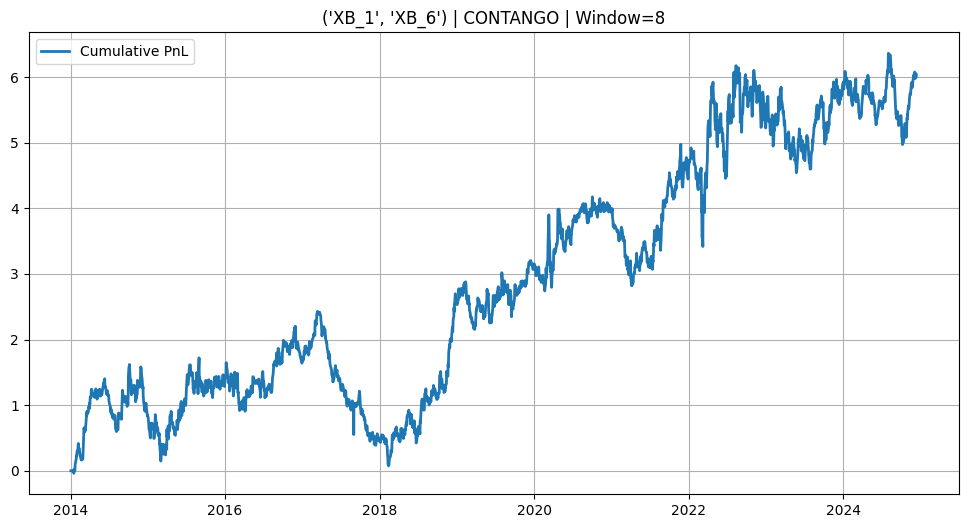

Executing BACKWARDATION Strategy for Seasonal Data
Ticker = ('XB_1', 'XB_6')

Best Window=2, Total Absolute Return=8.7241
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       2.6950      2.5264             0            0        0.0000  \
2014-01-03       2.6488      2.4956             0            0       -0.0462   
2014-01-06       2.6460      2.5018             0            0       -0.0028   
2014-01-07       2.6786      2.5143            -1            1        0.0326   
2014-01-08       2.6563      2.5009             1           -1       -0.0223   

            Back_Change     PnL  
Date                             
2014-01-02       0.0000  0.0000  
2014-01-03      -0.0308  0.0000  
2014-01-06       0.0062 -0.0000  
2014-01-07       0.0125 -0.0451  
2014-01-08      -0.0134 -0.0357  


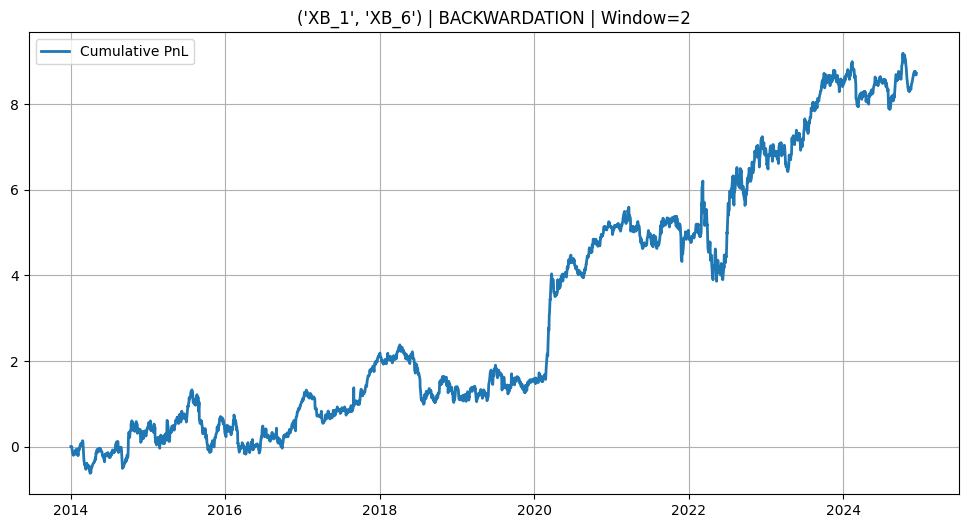

In [20]:
# Get the list of market types
types = list(symbols.keys())

# Dictionary to store the best window and results
best_results_dict = {}

# Main loop
for ty in types:
    tics = symbols[ty]
    print(f"\nProcessing Market Type: {ty.upper()}")

    for tic in tics:
        print(f"\n--- Processing Ticker Pair: {tic} ---")

        if ty != "seasonal":
            # Execute the strategy for non-seasonal data
            print(f"Executing {ty.upper()} Strategy")
            try:
                best_window, best_return, best_results = tune_ticker(tic, ty)
                best_results_dict[(ty, tic)] = {'Best_Window': best_window, 'Best_Return': best_return, 'Results': best_results}
            except Exception as e:
                print(f"Error processing {tic} in {ty}: {e}")
        else:
            # Execute contango and backwardation strategies for seasonal data
            for strat in ['contango', 'backwardation']:
                print(f"Executing {strat.upper()} Strategy for Seasonal Data")
                try:
                    best_window, best_return, best_results = tune_ticker(tic, strat, source='seasonal')
                    best_results_dict[(strat, tic)] = {'Best_Window': best_window, 'Best_Return': best_return, 'Results': best_results}
                except Exception as e:
                    print(f"Error processing {tic} in {strat} (Seasonal): {e}")


In [21]:
# Check best results
for key, value in best_results_dict.items():
    print(f"\nMarket/Strategy: {key[0]}, Ticker: {key[1]}")
    print(f"Best Window: {value['Best_Window']}, Total Return: {value['Best_Return']:.4f}")
    print(value['Results'].head())



Market/Strategy: contango, Ticker: ('HG_1', 'HG_6')
Best Window: 25, Total Return: 8.1725
            Front_Price  Back_Price  Weight_Front  Weight_Back  Front_Change   
Date                                                                           
2014-01-02       3.3815      3.3485             0            0        0.0000  \
2014-01-03       3.3550      3.3230             0            0       -0.0265   
2014-01-06       3.3595      3.3260             0            0        0.0045   
2014-01-07       3.3595      3.3290             0            0        0.0000   
2014-01-08       3.3425      3.3160             0            0       -0.0170   

            Back_Change  PnL  
Date                          
2014-01-02       0.0000  0.0  
2014-01-03      -0.0255  0.0  
2014-01-06       0.0030  0.0  
2014-01-07       0.0030  0.0  
2014-01-08      -0.0130  0.0  

Market/Strategy: contango, Ticker: ('ALE_1', 'ALE_6')
Best Window: 3, Total Return: 6172.5000
            Front_Price  Back_Price 

In [22]:
def max_drawdown(cumulative_values):
    """
    Calculate the maximum drawdown.
    Args:
        cumulative_values (pd.Series): The cumulative portfolio values.
    Returns:
        max_drawdown (float): The maximum drawdown value as a percentage.
    """
    # Calculate the running maximum
    running_max = cumulative_values.cummax()
    drawdown = (cumulative_values - running_max) / running_max
    max_drawdown = drawdown.min()
    return max_drawdown


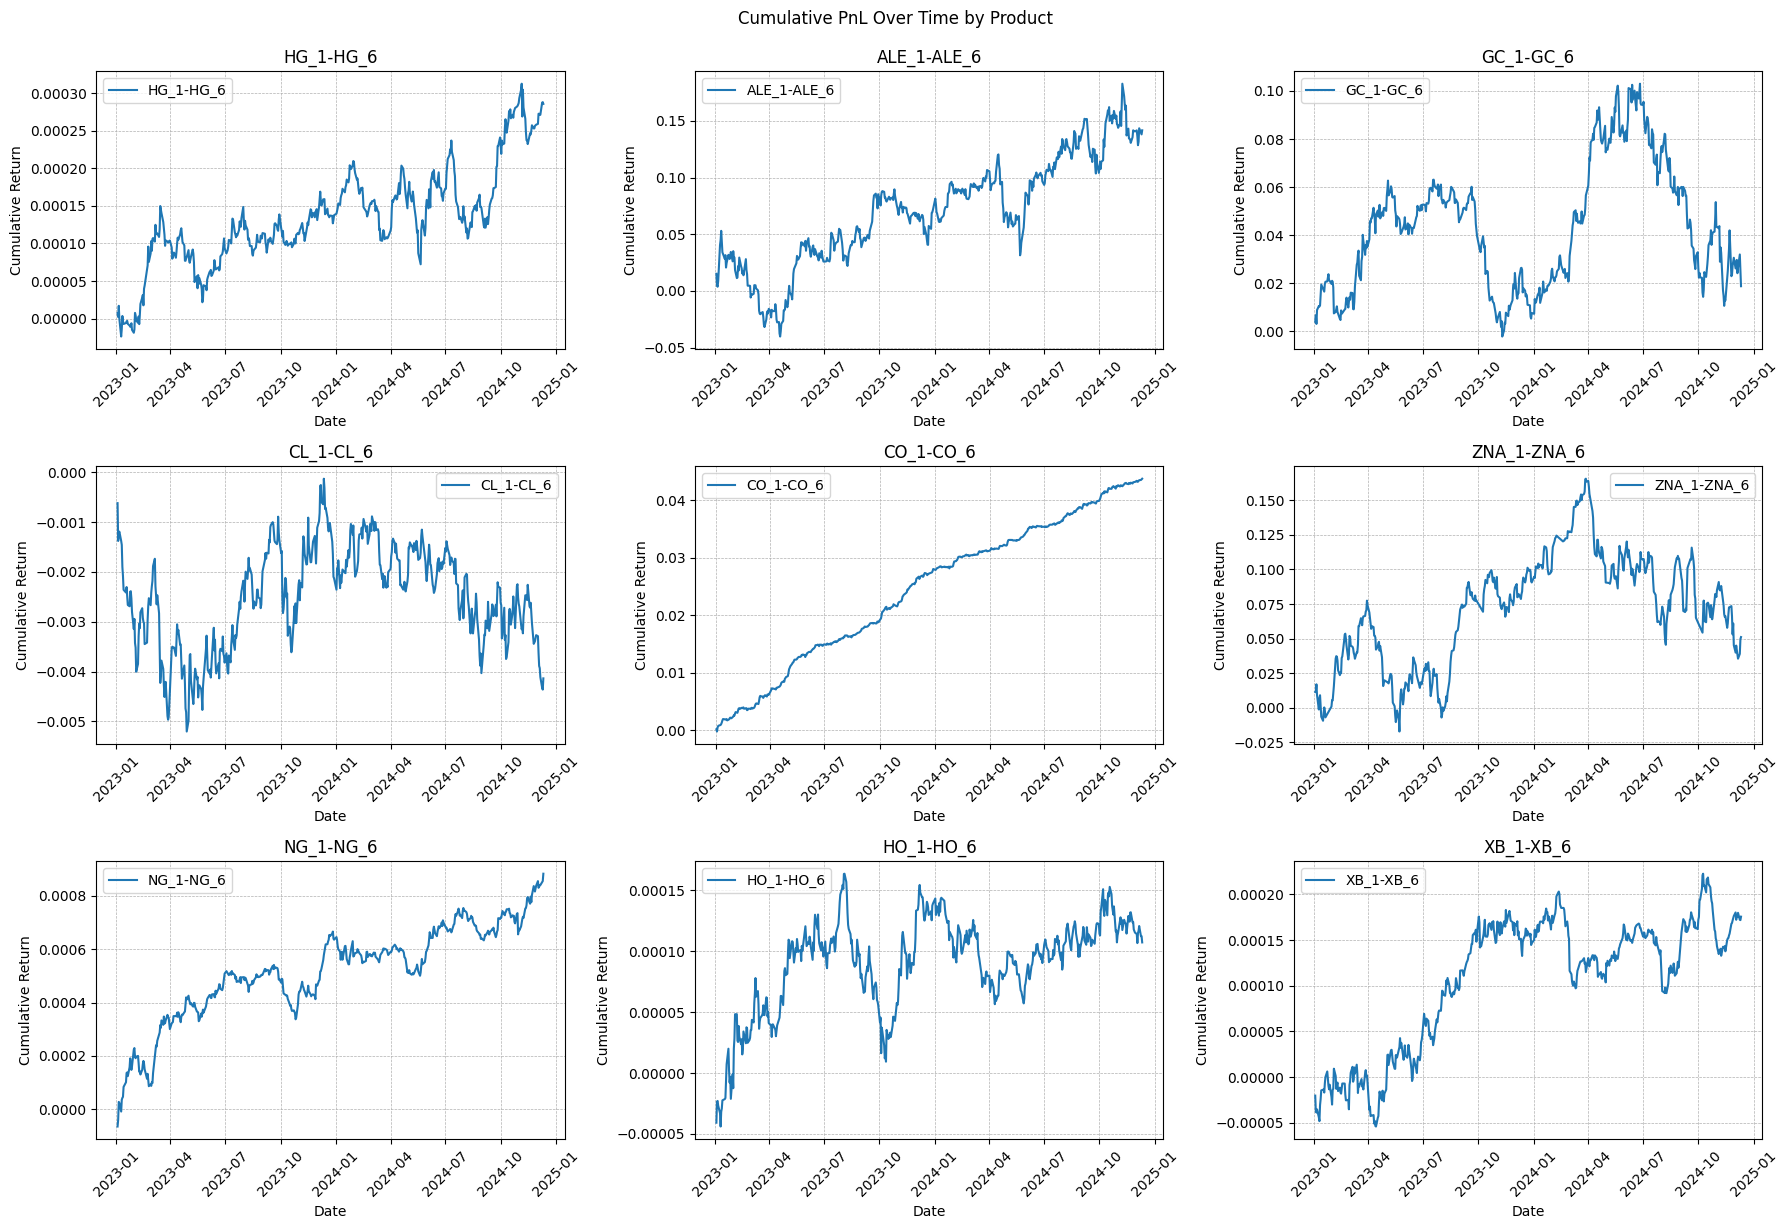

In [23]:
# Set initial capital and start date
initial_value = 10000
start_date = '2023-01-01'

filtered_results = {}

for key, value in best_results_dict.items():
    strategy, ticker_pair = key
    label_key = f"{ticker_pair[0]}-{ticker_pair[1]}"
    results = value['Results'].loc[start_date:].copy()

    if results.empty:
        print(f"No data available for {ticker_pair} after {start_date}")
        continue

    cumulative_value = results['PnL'].cumsum() + initial_value
    total_return = (cumulative_value.iloc[-1] - initial_value) / initial_value
    mdd = max_drawdown(cumulative_value)

    # If this pair already exists, compare returns and keep the better one
    if label_key not in filtered_results or total_return > filtered_results[label_key]['Total_Return']:
        filtered_results[label_key] = {
            'Strategy': strategy,
            'Cumulative_Value': cumulative_value,
            'Total_Return': total_return,
            'Max_Drawdown': mdd
        }



# Create a 3x3 subplot layout
num_tickers = len(filtered_results)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3 rows x 3 columns grid layout
axes = axes.flatten()  # Flatten the 2D axes array into 1D for easy iteration

# Plot cumulative returns for each ticker in individual subplots
for i, (label, data) in enumerate(filtered_results.items()):
    cumulative_value = data['Cumulative_Value']

    axes[i].plot(cumulative_value / initial_value - 1, label=label)
    axes[i].set_title(label)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Cumulative Return")
    axes[i].grid(visible=True, which='major', linestyle='--', linewidth=0.5)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility
    axes[i].legend()

# Hide extra subplots if there are fewer than 9 tickers
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust subplot layout and display the figure
plt.tight_layout()
plt.suptitle("Cumulative PnL Over Time by Product", y=1.02)
plt.show()


In [24]:
print("\nFinal Total Return and Max Drawdown Results:")
print(f"{'Ticker':<20} {'Strategy':<15} {'Total Return (%)':>10} {'Max Drawdown (%)':>15}")
print("-" * 70)
for label_key, data in filtered_results.items():
    strategy = data['Strategy']
    total_return = data['Total_Return'] * 100
    max_drawdown_pct = data['Max_Drawdown'] * 100
    print(f"{label_key:<20} {strategy.upper():<15} {total_return:>10.2f} {max_drawdown_pct:>15.2f}")



Final Total Return and Max Drawdown Results:
Ticker               Strategy        Total Return (%) Max Drawdown (%)
----------------------------------------------------------------------
HG_1-HG_6            CONTANGO              0.03           -0.01
ALE_1-ALE_6          CONTANGO             14.16           -8.85
GC_1-GC_6            CONTANGO              1.88           -8.38
CL_1-CL_6            BACKWARDATION        -0.41           -0.46
CO_1-CO_6            BACKWARDATION         4.38           -0.05
ZNA_1-ZNA_6          BACKWARDATION         5.11          -11.16
NG_1-NG_6            CONTANGO              0.09           -0.02
HO_1-HO_6            BACKWARDATION         0.01           -0.02
XB_1-XB_6            BACKWARDATION         0.02           -0.01
